In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from dataImporter import *
from dataProcesser import *
from events import sim_events, list_of_params, ic_params
from functions import perform_chisq
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)

IC_observed_full = np.array(get_IC_data().T)
E_rate, z_rate = get_flux_factor()
flux_E_factors_full, flux_z_factors_full = bin_flux_factors(E_rate,z_rate)
EFrom,ETo,zFrom,zTo = 3,13,0,11
z_bins = np.arange(zFrom,zTo)
E_bins, z_bins_T = np.arange(EFrom,ETo), np.arange(zFrom,zTo)[:,None]
n_Ebins, n_zbins = len(E_bins), len(z_bins)
flux_E_factors = flux_E_factors_full[E_bins]
flux_z_factors = flux_z_factors_full[z_bins]
flux_factors = np.outer(flux_E_factors, flux_z_factors)
IC_observed = IC_observed_full[E_bins,z_bins_T].T
#IC_observed_2017 = np.array(pd.read_csv('./pre_computed/IC_observed_2017.csv', header=None))

In [3]:
giunti_contour_cl90 = pd.read_csv('./data/giunti_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl90 = pd.read_csv('./data/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv('./data/giunti_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl99 = pd.read_csv('./data/ic_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')

E_ratios_full = pd.read_csv('./data/E_ratios.csv', header=None, names=['Ereco', 'Eratio']).Eratio.values
z_ratios_full = pd.read_csv('./data/z_ratios.csv', header=None, names=['zreco', 'zratio']).zratio.values
IC_per_z_full = np.array(np.sum(IC_observed_full, axis=0))
IC_per_E_full = np.array(np.sum(IC_observed_full, axis=1))
MC_per_E_full = (IC_per_E_full/E_ratios_full)
MC_per_z_full = (IC_per_z_full/z_ratios_full)

MC_ratios_full = np.outer(E_ratios_full, z_ratios_full)
IC_MC_full = IC_observed_full / MC_ratios_full
IC_MC = IC_MC_full[EFrom:ETo+1,z_bins]
#IC_MC_2017 = np.load('./pre_computed/IC_MC.npy')[E_bins,z_bins_T].T #Dont use this

In [4]:

Ereco_full = 500*10**np.linspace(0.0,1.3,14)
Ereco_full_midpoints = Ereco_full[0:-1] +np.diff(Ereco_full)/2 #For scatter plot

Ereco = Ereco_full[EFrom:ETo+1]
Ereco_midpoints= Ereco_full_midpoints[3:14]

zreco_full = np.linspace(-1,0,21)
zreco_full_midpoints = zreco_full[0:-1] +np.diff(zreco_full)/2 #For scatter plot

zreco = zreco_full[zFrom:zTo+1]
zreco_midpoints = zreco_full_midpoints[z_bins]


In [5]:
def to_hist(arr):
    return arr.tolist() + [arr[-1]]


def count_plots(H1,H0):
    IC_per_z = np.sum(IC_observed, axis=0)
    IC_per_E = np.sum(IC_observed, axis=1)

    IC_rate_z = IC_per_z /np.sum(H0, axis= 0)
    IC_rate_E = IC_per_E /np.sum(H0, axis= 1)

    H1_per_z_hist = to_hist(np.sum(H1, axis= 0))
    H1_per_E_hist = to_hist(np.sum(H1, axis= 1))
    H0_per_z_hist = to_hist(np.sum(H0, axis= 0))
    H0_per_E_hist = to_hist(np.sum(H0, axis= 1))

    H1_rate_z_hist = to_hist(np.sum(H1, axis= 0) / np.sum(H0, axis= 0))
    H1_rate_E_hist = to_hist(np.sum(H1, axis= 1) / np.sum(H0, axis= 1))
    H0_rate_z_hist = to_hist(np.sum(H0, axis= 0) / np.sum(H0, axis= 0))
    H0_rate_E_hist = to_hist(np.sum(H0, axis= 1) / np.sum(H0, axis= 1))

    fig, ax = plt.subplots(2,2, sharex='col', squeeze=True,gridspec_kw={'width_ratios': [3, 3], 'height_ratios':[3,1]}, figsize=(12,8))
    ax = ax.flatten()

    ax[0].scatter(Ereco_midpoints, IC_per_E, label='IC data', s=10, color='black', zorder=10)
    ax[0].step(Ereco, H1_per_E_hist, label='Sterile',lw=3, where='post', color='blue')
    ax[0].step(Ereco, H0_per_E_hist, label='Null',   lw=1.5, where='post', color='red')
    
    ax[1].scatter(zreco_midpoints, IC_per_z, label='IC data', s=10, color='black',zorder=10)
    ax[1].step(zreco, H1_per_z_hist, label='Sterile',lw=3, where='post', color='blue')
    ax[1].step(zreco, H0_per_z_hist, label='Null',   lw=1.5, where='post', color='red')

    ax[2].scatter(Ereco_midpoints, IC_rate_E, label='IC data',  s=10, color='black',zorder=10)
    ax[2].step(Ereco, H1_rate_E_hist, label='Sterile',lw=3, where='post', color='blue')
    ax[2].step(Ereco, H0_rate_E_hist, label='Null',   lw=1.5, where='post', color='red')
    
    ax[3].scatter(zreco_midpoints, IC_rate_z, label='IC data',  s=10, color='black',zorder=10)
    ax[3].step(zreco, H1_rate_z_hist, label='Sterile',lw=3, where='post', color='blue')
    ax[3].step(zreco, H0_rate_z_hist, label='Null',   lw=1.5, where='post', color='red')


    ax[0].set_xlim((Ereco.min(),Ereco.max()))
    ax[0].set_ylabel('Counts')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')

    ax[2].set_xscale('log')
    ax[2].set_xlabel(r'$E_\mu^{reco}$ [GeV]')
    ax[2].set_ylabel('Ratio to Null')
    ax[2].grid(True,which='both', axis='both', alpha=0.3)

    ax[3].set_xlim((zreco.min(),zreco.max()))
    ax[3].set_ylim(ax[2].get_ylim())
    ax[3].grid(True,which='both', axis='both', alpha=0.3)
    ax[3].set_xlabel(r'$\cos{(\theta^{reco}_z)}$')
    
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0,0.4))
    plt.subplots_adjust(hspace=0.05)


def get_boundary(arr):
    returned = []
    for i in range(len(arr)):
        try:
            returned.append((np.max(np.nonzero(arr[:,i]==True))+1))
        except ValueError:
            returned.append(0)
    return np.array(returned)
def fill_short_params(array):
    short_list = np.array(list_of_params(ic_params, dm41_range, s24_range,s24_eq_s34=False, short=True))
    long_list = np.array(list_of_params(ic_params, dm41_range, s24_range,s24_eq_s34=False, short=False)) 
    full_array = np.empty(len(long_list))
    full_array.fill(np.nan)
    for i,item in enumerate(short_list):
        index = np.where(item == long_list)[0].astype('int')
        full_array[index] = array[i]
    full_array = full_array.reshape(len(dm41_range),len(s24_range))
    return full_array

In [6]:
def norm_plot(simulated_events):
    normalization = IC_observed/simulated_events
    n_zbins, n_Ebins = normalization.shape
    fig, ax = plt.subplots()

    fig.set_size_inches(18.5, 10.5)
    im = ax.imshow(normalization,cmap="GnBu",origin='lower', extent= (0, n_zbins, 0, n_Ebins))
    cbar = ax.figure.colorbar(im, ax=ax)
    #cbar.formatter.set_powerlimits((0, 0))
    '''
    for i in range(n_Ebins):
        for j in range(n_zbins):
            text = ax.text(j+0.5, i+0.5, np.round(np.asarray(normalization)[j,i],1),
                ha="center", va="center", color="black")

    ax.set_xlabel(r'$\cos{(\theta_z)}$ bins', fontsize=20)
    ax.set_ylabel(r'$E_{\nu}$ bins', fontsize=20)
    ax.set_title('Ratio of observed IC events to my null hypothesis\n', fontsize=20)
    ax.set_xticks(np.arange(n_zbins+1))
    ax.set_xticklabels(np.round(np.linspace(-0.9,-0.1,n_zbins+1),2), fontsize = 13)
    ax.set_yticks(np.arange(n_Ebins+1))
    E_ticks = 500*10**np.linspace(0.3,1.3,n_Ebins+1)
    ax.set_yticklabels(E_ticks.astype(int), fontsize=11)
    '''

def normalize_bin_by_bin(simulated_events, MC = True, MC_old=False, correct_flux=False):
    if MC_old:
        IC_events = IC_MC_2017
    elif MC:
        IC_events = IC_MC

    if correct_flux:
        simulated_events = flux_E_factors*simulated_events

    normalization = IC_events/simulated_events

    return np.array(normalization)


def is_precomputed(N,ndim, dict, check=False):
    for anti in [True,False]:
        for flavor_from in ['e','m']:
            flavor_to  = 'm'
            try:
                get_probabilities(flavor_from, flavor_to, 5,5,dict,anti,N)
            except FileNotFoundError:
                if check:
                    return False
                else:
                    raise FileNotFoundError(f'P{flavor_from}{flavor_to} for N={N}, dm={dict["dm_41"]}, s24={np.sin(2*dict["theta_24"])**2}, s34={np.sin(2*dict["theta_34"])**2}, not found')
            return True

def return_precomputed(N,ndim,params):
    params= np.array(params)
    precomputed_list = np.array([is_precomputed(N,ndim, p, check=True) for p in params])
    mask = precomputed_list == True
    computed_params = params[mask]
    return computed_params

In [7]:
ndim = 4
N = 9
alpha = 0.99
precomputed_events = True

In [45]:
dm41_range = np.logspace(-1,1,20)
s24_range = np.logspace(-2,0,20)
#s34_range = np.logspace(-2,0,10)
s34_range = s24_range
param_list = list_of_params(ic_params, dm41_range, s24_range,s24_eq_s34=True, short=False)
for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
    assert is_precomputed(N=N,ndim=ndim, dict=p,check=False)

In [46]:
param_list = return_precomputed(N,ndim,params=param_list)
dm41_range = np.sort(np.unique(np.array([p['dm_41'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
s34_range = np.sin(2*np.sort(np.unique(np.array([p['theta_34'] for p in param_list]))))**2
print(dm41_range)
print(s24_range)
print(s34_range)

[ 0.1         0.1274275   0.16237767  0.20691381  0.26366509  0.33598183  0.42813324  0.54555948  0.6951928   0.88586679  1.12883789  1.43844989  1.83298071  2.33572147  2.97635144  3.79269019
  4.83293024  6.15848211  7.8475997  10.        ]
[0.01       0.01274275 0.01623777 0.02069138 0.02636651 0.03359818 0.04281332 0.05455595 0.06951928 0.08858668 0.11288379 0.14384499 0.18329807 0.23357215 0.29763514 0.37926902 0.48329302 0.61584821
 0.78475997 1.        ]
[0.01       0.01274275 0.01623777 0.02069138 0.02636651 0.03359818 0.04281332 0.05455595 0.06951928 0.08858668 0.11288379 0.14384499 0.18329807 0.23357215 0.29763514 0.37926902 0.48329302 0.61584821
 0.78475997 1.        ]


In [47]:
if not precomputed_events:
    from multiprocessing import Pool
    p = Pool()
    data = [(alpha, N,p, False,False, [False, np.median(Ereco), gamma]) for p in param_list]
    H1_events_list = p.starmap(sim_events, data)
    p.close()
    if len(s34_range) > 1:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_34_N{N}_{len(dm41_range)}x{len(s24_range)}x{len(s34_range)}.p','wb'))
    else:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_no34_N{N}_{len(dm41_range)}x{len(s24_range)}.p','wb'))


    H0_events = sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[False, np.median(Ereco), gamma])
    pickle.dump(H0_events,open(f'./pre_computed/H0_N{N}.p','wb'))
if len(s34_range) > 1:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_34_N{N}_{len(dm41_range)}x{len(s24_range)}.p','rb'))
else:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_no34_N{N}_{len(dm41_range)}x{len(s24_range)}.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}.p','rb'))

In [38]:
gamma = 0.3
delta_T = (np.sum(sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[True, np.median(Ereco), gamma])) - np.sum(H0_events))/np.sum(H0_events)

In [48]:
norm_factors = normalize_bin_by_bin(H0_events[:,z_bins],MC=True)
H0_normalized = norm_factors *H0_events[:,z_bins]
H1_list_normalized = [norm_factors*H1[:,z_bins] for H1 in H1_events_list]

In [49]:
s24_cl90_index_list=[]
s24_cl99_index_list=[]
dm41_cl90_index_list=[]
dm41_cl99_index_list=[]
for x in [[1.],[1.,0.]]:
    sigma_a = 0.25
    sigma_b = 0.15
    sigma_g = delta_T
    f = 0.09
    sigma_syst = f*IC_observed
    x0=x
    #chisq_H0, a_H0 = perform_chisq(H0_normalized,IC_observed,z=zreco[0:-1],sigma_a=sigma_a,sigma_b=sigma_b,sigma_gamma=sigma_gamma , x0=x0)
    chisq_H1_list  = np.array([perform_chisq(H1_norm, IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g, x0=x0)[0] for H1_norm in H1_list_normalized])
    delta_chi = chisq_H1_list - np.min(chisq_H1_list)#chisq_H1_list - chisq_H0

    best_fit_index = np.argmin(delta_chi)
    best_fit_params = param_list[best_fit_index]
    best_fit_events = H1_list_normalized[best_fit_index]
    _, best_a =perform_chisq(H1_list_normalized[best_fit_index], IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1],sigma_a=sigma_a, sigma_b=sigma_b,sigma_g=sigma_g, x0=x0)
    p_value = chi2.sf(np.min(chisq_H1_list),2)

    if len(best_a) == 2:
        a = best_a[0]
        b = best_a[1]
        H1_best = a*(1+b*(0.5+zreco[0:-1]))*best_fit_events
    elif len(best_a) == 1:
        H1_best = best_a*best_fit_events

    '''
    print('best deltachi:', np.round(delta_chi[best_fit_index],4))
    print('best parameters:', best_a)
    #print('p-value:',p_value)
    print('best dm41:', np.round(best_fit_params['dm_41'],3))
    print('best s24:', np.round(np.sin(2*best_fit_params['theta_24'])**2,4))
    print('best s34:', np.round(np.sin(2*best_fit_params['theta_34'])**2,4))
    #print('best th24:', best_fit_params['theta_24'])
    #print(delta_chi)
    '''
    #deltachi_reshaped = fill_short_params(delta_chi).T
    deltachi_reshaped = delta_chi.reshape(len(dm41_range), len(s24_range))
    cl_99_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.99,df=2),True,False)
    cl_90_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.90,df=2),True,False)

    s24_cl90_index = get_boundary(cl_90_bool)
    dm41_cl90_index = np.linspace(0,len(s24_cl90_index)-1,len(s24_cl90_index)).astype('int')
    s24_cl99_index = get_boundary(cl_99_bool)
    dm41_cl99_index = np.linspace(0,len(s24_cl99_index)-1,len(s24_cl99_index)).astype('int')

    s24_cl90_index_list.append(s24_cl90_index)
    s24_cl99_index_list.append(s24_cl99_index)
    dm41_cl90_index_list.append(dm41_cl90_index)
    dm41_cl99_index_list.append(dm41_cl99_index)


Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.15$\n$\\Delta \\gamma = 0.3$\n$f = 0.09$\n')

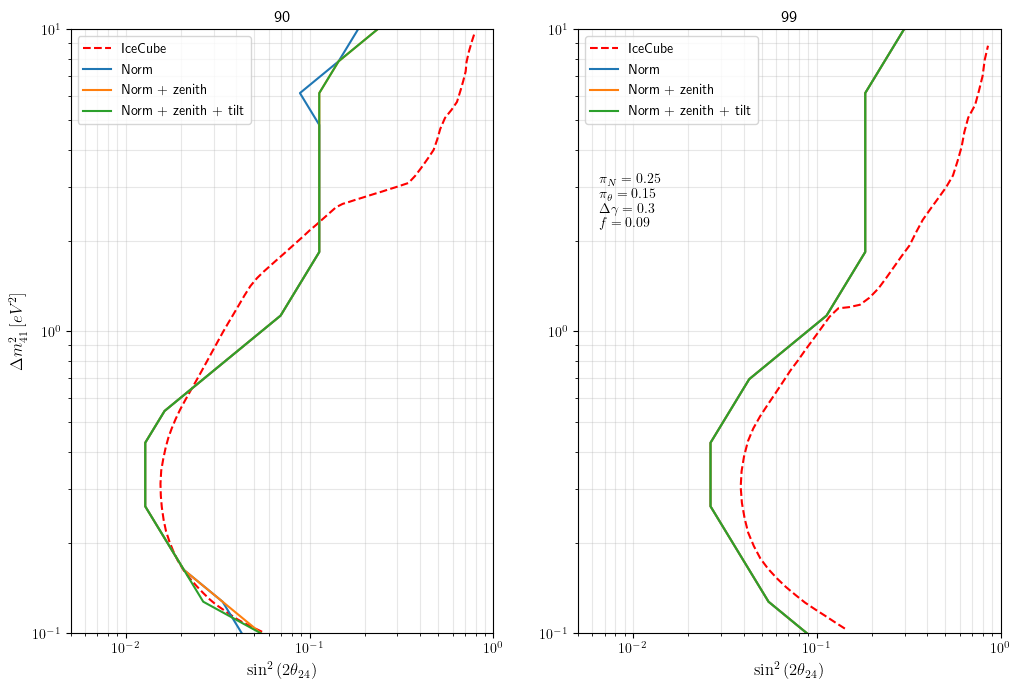

In [25]:
fig,ax = plt.subplots(1,2,figsize=(12,8))

#ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label='Giunti et al. (90% CL)',c='b')
ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label='IceCube',c='red',ls='--')
ax[0].plot(s24_range[s24_cl90_index_list[0]], dm41_range[dm41_cl90_index_list[0]], label='Norm')
ax[0].plot(s24_range[s24_cl90_index_list[1]], dm41_range[dm41_cl90_index_list[1]], label='Norm + zenith')
ax[0].plot(s24_range[s24_cl90_index_list[2]], dm41_range[dm41_cl90_index_list[2]], label='Norm + zenith + tilt')

#ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al. (99% CL)',ls='solid',c='b')
ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube',c='red',ls='--')
ax[1].plot(s24_range[s24_cl99_index_list[0]], dm41_range[dm41_cl99_index_list[0]], label='Norm')
ax[1].plot(s24_range[s24_cl99_index_list[1]], dm41_range[dm41_cl99_index_list[1]], label='Norm + zenith')
ax[1].plot(s24_range[s24_cl99_index_list[2]], dm41_range[dm41_cl99_index_list[2]], label='Norm + zenith + tilt')


ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-1,1e1))
ax[1].set_ylim((1e-1,1e1))
ax[0].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[1].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[0].set_ylabel('$\\Delta m^2_{41} \, [eV^2]$', fontsize=12)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title('90% CL')
ax[1].set_title('99% CL')

ax[0].legend()
ax[1].legend()
plt.annotate(f'$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n', 
        xy=(0.05, 0.65), xycoords='axes fraction')

#interpolare contour mesh

In [51]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter
temp_params = list_of_params(ic_params, np.array([0.5]), np.array([0.02]), np.array([0,0.02]))
Pam = P_over_E_parameter('m', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=True)
Pm = P_over_E_parameter('m', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=False)
Pe = P_over_E_parameter('e', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=False)
Pae = P_over_E_parameter('e', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=True)

Pamam = Pam[:,1]
Pmm = Pm[:,1]
Pem = Pe[:,1]
Paeam = Pae[:,1]

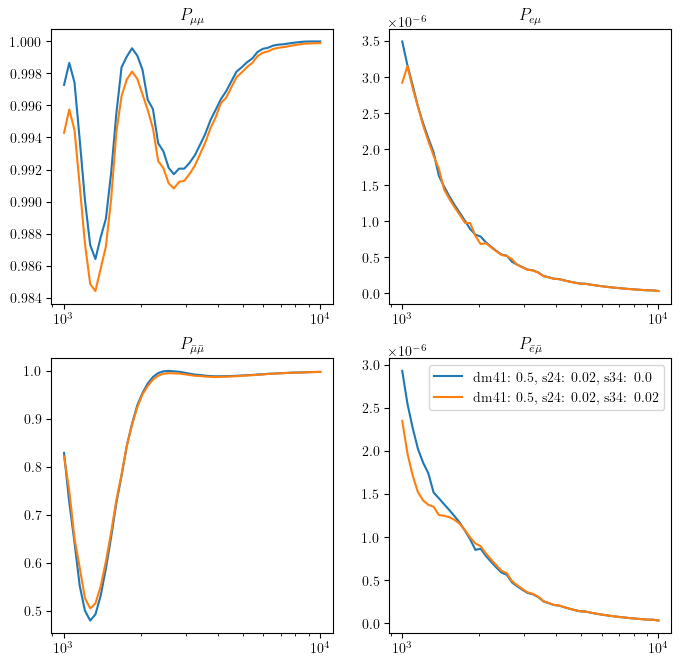

In [52]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax = ax.flatten()
for i,prob in enumerate(Pmm):
    ax[0].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
for i,prob in enumerate(Pem):
    ax[1].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
for i,prob in enumerate(Pamam):
    ax[2].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
for i,prob in enumerate(Paeam):
    ax[3].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')

ax[0].set_title('$P_{\mu\mu}$')
ax[1].set_title('$P_{e\mu}$')
ax[2].set_title('$P_{\\bar{\mu}\\bar{\mu}}$')
ax[3].set_title('$P_{\\bar{e}\\bar{\mu}}$')
plt.legend()

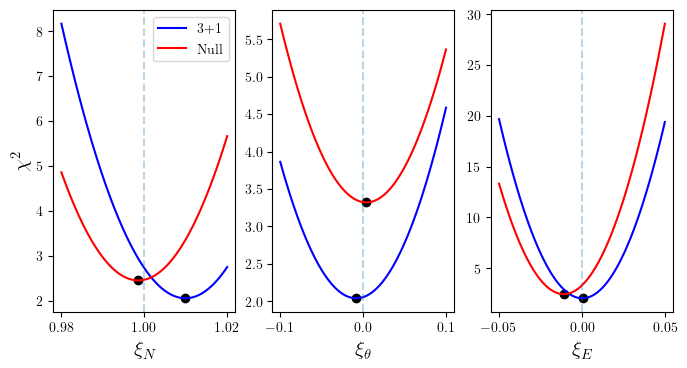

In [469]:
from functions import chisq
fig, ax = plt.subplots(1,3)
c_range = np.linspace(-0.05,0.05,100)
b_range = np.linspace(-0.1,0.1,100)
a_range = np.linspace(0.98,1.02,100)
H1_a = [chisq(params =[a,best_a[1]] ,events=best_fit_events, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for a in a_range]
H0_a = [chisq(params =[a,best_a[1]] ,events=H0_normalized, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for a in a_range]
H0_min_a = np.argmin(H0_a)
H1_min_a = np.argmin(H1_a)
ax[0].plot(a_range, H1_a, label='3+1', c='blue')
ax[0].plot(a_range, H0_a, label='Null', c='red')
ax[0].scatter(a_range[H0_min_a], H0_a[H0_min_a], c='black')
ax[0].set_xlabel('$\\xi_N$', fontsize=15)
ax[0].set_ylabel('$\chi^2$', fontsize=15)
ax[0].scatter(a_range[H1_min_a], H1_a[H1_min_a], c='black')
ax[0].legend()
ax[0].axvline(x=1, linestyle='--',alpha=0.3)


H1_b = [chisq(params =np.array([best_a[0],b]) ,events=best_fit_events, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for b in b_range]
H0_b = [chisq(params =np.array([best_a[0],b]) ,events=H0_normalized, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for b in b_range]
H0_min_b = np.argmin(H0_b)
H1_min_b = np.argmin(H1_b)
ax[1].plot(b_range, H1_b, label='3+1', c='blue')
ax[1].plot(b_range, H0_b, label='Null', c='red')
ax[1].scatter(b_range[H0_min_b], H0_b[H0_min_b], c='black')
ax[1].set_xlabel('$\\xi_\\theta$', fontsize=15)
ax[1].scatter(b_range[H1_min_b], H1_b[H1_min_b], c='black')
ax[1].axvline(x=0, linestyle='--',alpha=0.3)

H1_c = [chisq(params =np.array([best_a[0],best_a[1], c]) ,events=best_fit_events, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for c in c_range]
H0_c = [chisq(params =np.array([best_a[0],best_a[1], c]) ,events=H0_normalized, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for c in c_range]
H0_min_c = np.argmin(H0_c)
H1_min_c = np.argmin(H1_c)
ax[2].plot(c_range, H1_c, label='3+1', c='blue')
ax[2].plot(c_range, H0_c, label='Null', c='red')
ax[2].scatter(c_range[H0_min_c], H0_c[H0_min_c], c='black')
ax[2].set_xlabel('$\\xi_E$', fontsize=15)
ax[2].scatter(c_range[H1_min_c], H1_c[H1_min_c], c='black')
ax[2].axvline(x=0, linestyle='--',alpha=0.3)